# Column generation and vehicle routing

So clearly, we can get a good solution (maybe even an optimal one!) to the problem with a restricted set of routes.

Let's consider the linear relaxation of the problem, denoted by (P):

\begin{align*}
    \tag{P}
    \min \quad 
    & \sum_{r\in\mathcal{R}} c_r x_r
    \\
    \text{s.t.} \quad 
    & \sum_{r\in\mathcal{R}} \gamma_{i,r} x_r = 1 
    && \forall i \in \mathcal{N}_C 
    \\
    & x_r \geq 0
    && \forall r \in \mathcal{R}
\end{align*}

Notice that we've eliminated the upper bounds on $x_r$. It doesn't break the validity of the formulation, because from any solution with $x_r>1$, we can construct a feasible solution with $x_r'=1$ which lowers the total cost by $c_r (x_r-1)$.


In [3]:
using Plots, Random, LinearAlgebra, Printf, JLD, Distributions, Combinatorics, Graphs

In [4]:
using JuMP, Gurobi
const GRB_ENV = Gurobi.Env()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-18


Gurobi.Env(Ptr{Nothing} @0x000000029e05ee00, false, 0)

## 0: Data loading

In [5]:
struct VehicleRoutingData
    capacity::Int
    num_vehicles::Int
    num_customers::Int
    distances::Matrix{Float64}
    locations::Matrix{Float64}
    demand::Vector{Int}
end


In [6]:
data = load("data_large.jld", "data_large")

VehicleRoutingData(30, 8, 50, [0.0 34.20704169593714 … 50.07584207909189 29.456584836363835; 34.20704169593714 0.0 … 39.87558477618905 8.98225323192642; … ; 50.07584207909189 39.87558477618905 … 0.0 32.736962448228745; 29.456584836363835 8.98225323192642 … 32.736962448228745 0.0], [57.986212013413244 21.64667906754636; 41.129411794985046 51.41192705884623; … ; 77.49752377279368 67.76499075995778; 50.0 50.0], [5, 6, 2, 2, 2, 5, 7, 4, 2, 3  …  3, 4, 3, 4, 4, 5, 5, 5, 3, 3])

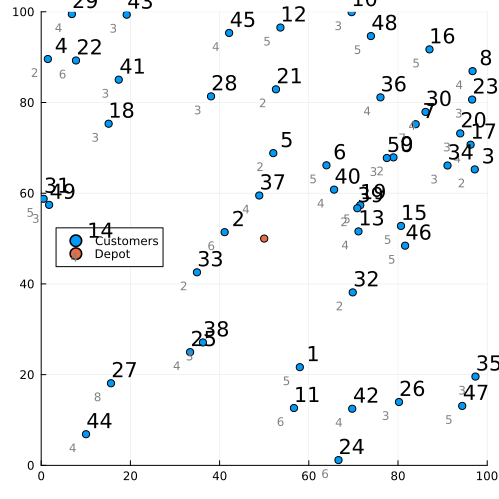

In [7]:
function plot_from_data(
    data::VehicleRoutingData,
)
    """Given a problem instance, plot it.
    """
    N = data.num_customers
    pl = plot(
        size = (500,500), 
        xlim = (0, 100), 
        ylim = (0, 100),
    )
    for i in 1:N
        annotate!(
            data.locations[i,1] + 3, 
            data.locations[i,2] + 3, 
            text("$i")
        )
        annotate!(
            data.locations[i,1] - 3, 
            data.locations[i,2] - 3, 
            text("$(data.demand[i])", :gray, 8),
        )
    end
    scatter!(
        data.locations[1:N, 1], 
        data.locations[1:N, 2], 
        label = "Customers",
    )
    scatter!(
        data.locations[[N+1], 1], 
        data.locations[[N+1], 2], 
        label = "Depot"
    )
    scatter!(
        legend = :left,
    )
    return pl
end
plot_from_data(data)

## 1: Direct solve

Here, we solve Formulation (1) directly.

In [ ]:
function direct_solve(
    data::VehicleRoutingData,
    ;
    time_limit::Int = 60,
)
    """Solves the problem directly, using Formulation (1);
    Use this function to debug your solution.
    """
    
    K = data.num_vehicles
    N = data.num_customers

    model = Model(Gurobi.Optimizer)
    set_time_limit_sec(model, time_limit)
    @variable(model, y[1:N+1,1:N+1,1:K], Bin)
    @variable(model, z[1:N,1:K], Bin)
    

    @constraint(
        model, 
        [k in 1:K],
        sum(y[N+1,j,k] for j in 1:N+1) == 1
    )
    @constraint(
        model, 
        [i in 1:N+1, k in 1:K],
        y[i,i,k] == 0
    )
    @constraint(
        model, 
        [i in 1:N+1, k in 1:K],
        sum(y[i,j,k] for j in 1:N+1) 
        == sum(y[j,i,k] for j in 1:N+1) 
    )
    @constraint(
        model,
        [i in 1:N+1, k in 1:K],
        sum(y[i,j,k] for j in 1:N+1) 
        ≤ 1
    )
    for S in combinations(1:N)
        @constraint(
            model,
            [k in 1:K],
            sum(y[i,j,k] for i in S, j in S) ≤ length(S) - 1
        )
    end
    @constraint(
        model, 
        [i = 1:N, k in 1:K],
        z[i,k] == sum(y[i,j,k] for j in 1:N+1)
    )
    @constraint(
        model,
        [i in 1:N],
        sum(z[i,k] for k in 1:K) == 1
    )
    @constraint(
        model, 
        [k in 1:K],
        sum(data.demand[i] * z[i,k] for i in 1:N) ≤ data.capacity
    )
    @objective(
        model,
        Min,
        sum(data.distances[i,j] * y[i,j,k] for i in 1:N+1, j in 1:N+1, k in 1:K)
    )
    
    time_taken = @elapsed optimize!(model)

    return Dict(
        "y" => value.(y),
        "z" => value.(z),
        "time" => time_taken,
        "objective" => objective_value(model),
    )
end

In [9]:
direct_solution = direct_solve(data);

426

## 2: Utilities

We provide here a utility function `find_subtours()` that finds subtours in a given route solution.

In [8]:
function find_subtours(
    N::Int,
    sol::Array{Float64, 2},
)
    """
    Given a solution (provided as a N+1 by N+1 array,
    with `sol[i,j] == 1.0` whenever the arc `i->j` is in the route),
    produces a list of components (as a Vector{Vector{Int}}) 
    where each component consists of the nodes that are "connected".
    """
    @assert size(sol) == (N+1, N+1)
    g = DiGraph(N+1)
    for ind in findall(x -> (x > 0.5), sol)
        add_edge!(g, ind[1], ind[2])
    end
    components = strongly_connected_components(g)

    ind = findfirst(x -> (N+1 in x), components)
    subtour = popat!(components, ind)
    i = findfirst(x -> x == N+1, subtour)
    new_subtour = vcat(subtour[i:end], subtour[1:i-1])
    insert!(components, 1, new_subtour)

    return components
end

find_subtours (generic function with 1 method)

Here is a utility function `plot_from_solution()` that plots a integral solution to the direct formulation visually.

In [9]:
function plot_from_solution(
    data::VehicleRoutingData,
    y::Array{Float64, 3},
)
    """Given a problem instance and a corresponding (Formulation 1) solution, plot it.
    """
    N = data.num_customers
    K = data.num_vehicles
    pl = plot_from_data(data)
    for k in 1:K
        nodes = find_subtours(N, y[:,:,k])[1]
        push!(nodes, N+1)
        plot!(
            data.locations[nodes, 1],
            data.locations[nodes, 2],
            label = "Vehicle $k",
        )
    end
    return pl
end

plot_from_solution (generic function with 1 method)

Let's visualize the solution obtained via the direct formulation!

In [10]:
# plot_from_solution(data, direct_solution["y"])

## 3: Column generation

Here is some code to get you started. We define a route as a struct (a Julia object) with the following attributes: `arcs` (a vector of its arcs, each being a tuple of nodes), `cost` (its cost), and `customers` (a vector of nodes corresponding to customers it visits).

In [11]:
struct Route
    arcs::Vector{Tuple{Int,Int}}
    cost::Float64
    customers::Vector{Int}
end

Q: Given a route, how would you compute its cost?

In [12]:
function compute_route_cost(
    data::VehicleRoutingData,
    arcs::Vector{Tuple{Int,Int}},
)
    """
    Computes the cost of a route, given its sequence of arcs.
    (TODO)
    """
    return sum(data.distances[arc...] for arc in arcs)
end

compute_route_cost (generic function with 1 method)

We first implement a heuristic way of finding initial feasible routes. Here they only need to be feasible (satisfying each vehicle's capacity constraint) and the routes are in general far from optimal.

In [13]:
function initial_routes(
    data::VehicleRoutingData
    ;
)
    """
    Given a problem instance, generates a feasible set of routes.
    These routes are generated such that they satisfy the capacity constraint,
    but need not be "cheap".
    """
    N = data.num_customers
    Q = data.capacity
    # Iterates until termination
    while true 
        # Performs a random shuffle of the customers
        shuffled_indices = randperm(data.num_customers)
        arcs = Tuple{Int,Int}[]
        all_arcs = Vector{Tuple{Int,Int}}[]
        current = N+1
        total = 0
        # Greedily add customers to each route until capacity is violated, 
        # start a new route if capacity is about to be violated.
        for c in shuffled_indices
            d = data.demand[c]
            
            if total + d > Q
                push!(arcs, (current, N+1))
                push!(all_arcs, arcs)
                arcs = []
                total = 0
                current = N+1
            end
            total += d
            push!(arcs, (current, c))
            current = c
        end
        push!(arcs, (current, N+1))
        push!(all_arcs, arcs)
        # Check if the total number of routes generated is ≤ K
        if length(all_arcs) ≤ data.num_vehicles
            return [
                Route(
                    arcs,
                    compute_route_cost(data, arcs),
                    [x[2] for x in arcs[1:end-1]],
                )
                for arcs in all_arcs
            ]
        end
    end
end

initial_routes (generic function with 1 method)

We implement this in the function `new_route()` below. Note that we had to use lazy callbacks to deal with the exponential number of subtour elimination constraints in the formulation. **This function is incomplete: please fill in the rest of the function.**

In [14]:
function compute_route_reduced_cost(
    data::VehicleRoutingData,
    route::Route,
    p::Vector{Float64}, 
    q::Float64, #??
)
    """
    Computes reduced cost of a route according to dual variables p and q.
    DONE
    """
    N = data.num_customers
    return (
        compute_route_cost(data, route.arcs) #c_ij
        - sum(p[i] for i in 1:N if i in route.customers) #p_i
    )
end

compute_route_reduced_cost (generic function with 1 method)

In [15]:
function new_route(
    data::VehicleRoutingData,
    p::Vector{Float64}, #number of 
    q::Float64, # sum_x < k (number of vehicles i.e. paths we generate)
)
    """
    Given dual variables p and q, 
    find a new route to add with minimum reduced cost.
    (DONE)
    """

    N = data.num_customers
    Q = data.capacity
    d = data.demand
    
    """
    (DONE)
    """
    modified_costs = copy(data.distances)
    for i in 1:N
        modified_costs[i,:] = modified_costs[i,:] .- p[i] #c_ij - lambda_i from davy's discussion
        #(1,0,1) modified costs dim is (i,j)
    end

    # Create subproblem model
    sp_model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        sp_model,
        "OutputFlag" => 0,
    )
    @variable(sp_model, w[i in 1:N+1, j in 1:N+1], Bin) # whether arc (i, j) is selected
    @variable(sp_model, z[i in 1:N], Bin) # whether the path visits customer i
    # N+1 is depot

    # Constraints
    """
    (DONE)
    """
    @constraint(
        sp_model,
        [i in 1:N],
        sum(w[j,i] for j in 1:N+1)
        == sum(w[i,j] for j in 1:N+1) 
    )
    @constraint( #starting from i, you only choose one after node
        sp_model,
        [i in 1:N+1], #was originally N in recitation code
        sum(w[i,j] for j in 1:N+1) 
        ≤ 1
    ) 
    @constraint(
        sp_model,
        [i in 1:N], #only Nc y_iik =0(1c)
        w[i,i] == 0 
    )
    @constraint(
        sp_model,
        sum(w[j,N+1] for j in 1:N+1) == 1
    )
    # @constraint( removed from recitation which is open
    #     sp_model,
    #     sum(w[N+1,j] for j in 1:N+1) == 0
    # )
    @constraint(
        sp_model, 
        [i in 1:N],
        z[i] == sum(w[i,j] for j in 1:N+1)
    )
    @constraint(
        sp_model, 
        sum(d[i]*z[i] for i in 1:N) ≤ Q #capacity
    )

    # Objective
    """
    (DONE)
    """
    @objective(
        sp_model,
        Min,
        sum(
            modified_costs[i,j] * w[i,j]
            for i in 1:N+1, j in 1:N+1
        ) - q
    )
    # Callback function to eliminate subtours
    # Uses the helper function `find_subtours`.
    function eliminate_subtours(cb_data)
        status = callback_node_status(cb_data, sp_model)
        if status == MOI.CALLBACK_NODE_STATUS_FRACTIONAL
            return
        elseif status == MOI.CALLBACK_NODE_STATUS_INTEGER
            sol = callback_value.(cb_data, w)
            subtours = find_subtours(N, sol)
            for subtour in subtours
                if length(subtour) == 1 || N+1 in subtour
                    continue
                else
                    cut = @build_constraint(
                        sum(w[i,j] for i in subtour, j in subtour)
                        ≤ length(subtour) - 1
                    )
                    MOI.submit(sp_model, MOI.LazyConstraint(cb_data), cut)
                end
            end
        end
    end
    MOI.set(sp_model, MOI.LazyConstraintCallback(), eliminate_subtours)

    optimize!(sp_model)

    # Compute route and reduced cost from solution
    """
    (DONE)
    """
    sol = value.(w)
    nodes = [N+1] #depo
    cnt =0
    while cnt != 1  #change to equal as it ends at depo??
        push!(nodes, argmax(sol[nodes[end],:])) #choosing 1 out of [0,0,1,0,0]
        if nodes[end]== N+1 #added some other nodes before hitting cnt
            cnt += 1
        end
    end
    arcs = collect(zip(nodes[1:end-1], nodes[2:end])) #arcs on a sequence of nodes i.e. path
    cost = compute_route_cost(data, arcs) 
    customers = nodes
    route = Route(
        arcs,
        cost,
        customers,
    )
    reduced_cost = compute_route_reduced_cost(data, route, p, q)

    return route, reduced_cost

end

new_route (generic function with 1 method)

We now implement the overall algorithm. **This function is incomplete: please fill in the rest of the function.**

In [16]:
function cvrp_column_generation(
    data::VehicleRoutingData,
    ;
    max_iterations::Int = 10000,
    verbose::Bool = true,
)
    """
    Column generation algorithm for the VRP.
    (DOing)
    """
    N = data.num_customers
    K = data.num_vehicles

    # Initialization
    CGLP_solution = nothing
    CGLP_objective = 0.0
    upper_bounds = []
    lower_bounds = []
    MP_time = []
    SP_time = []
    p_values = []
    q_values = []

    if verbose
        @printf("              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost\n")
    end

    # Creates initial routes
    routes = initial_routes(data)
    counter = 0

    while true
        counter += 1

        # Make restricted master problem with current routes 
        MP_start_time = time()
        model = Model(() -> Gurobi.Optimizer(GRB_ENV))
        set_optimizer_attributes(
            model,
            "OutputFlag" => 0,
        )

        """
        (DONE: Constraints and objective (over routes))
        """
        @variable(model, x[r in 1:length(routes)] ≥ 0)
        @constraint(
            model,
            visit_customer[i in 1:N], 
            sum(
                x[r] for r in 1:length(routes)
                if i in routes[r].customers #a_ip
            ) == 1
        )
        @constraint(
            model,
            k_vehicle,
            sum(
                x[r] for r in 1:length(routes)    
            ) == K
        )
        @objective(
            model, 
            Min,
            sum(x[r] * routes[r].cost for r in 1:length(routes))
        )
        optimize!(model)
        MP_end_time = time()

        """
        (DONE: get duals)
        """
        p = dual.(visit_customer)
        q = dual.(k_vehicle)
        push!(p_values, p)
        push!(q_values, q)
        # Update column generation metrics
        upper_bound = sum(p[i] for i in 1:N) + q * K # TODO
        push!(upper_bounds, upper_bound)
        push!(MP_time, MP_end_time - MP_start_time)

        # Upper bound of relaxation: u⊤b
        # – Upper bound of relaxation:
        # – (Weak) lower bound:
        # λ⊤ b + θ
        # u ⊤b + ¯c ∗κ, where κ ≥ ∑ j∈Jx j
        # upper bound doesn't fluctuate as fbl space mon.increase as we rlx (add col)
        # lower bound fluctuate as cbar from (lb = obj + cbar N) cbar is affected by dual var

        # Compute a new route to add and its corresponding reduced cost
        SP_start_time = time()
        """
        (TODO: solve subproblem)
        """
        route, reduced_cost = new_route(data, p, q) # TODO
        SP_end_time = time()
        # Update column generation metrics
        lower_bound =  objective_value(model) + N * reduced_cost # DONE
        push!(lower_bounds, lower_bound)
        push!(SP_time, SP_end_time - SP_start_time)

        if verbose
            # @printf("              | Objective | MP time (s) | SP time (s) | Reduced cost")
            @printf(
                "Iteration %3d | %9.3f | %11.3f |      %6.3f |      %6.3f | %12.3f\n",
                counter, 
                upper_bound,
                lower_bound,
                MP_time[end],
                SP_time[end],
                reduced_cost,
            )
            flush(stdout)
        end

        # Termination criteria w.o. ingrality of Ax>=b cstr
        if (
            reduced_cost > -1 #e-6
            || counter > 100 #max_iterations
        )  
            CGLP_solution = value.(x) #nothing # TODO
            CGLP_objective = objective_value(model) #nothing # TODO
            break
        end
        push!(routes, route)
    end

    """
    (TODO) Solve model again with the same variables, enforcing integrality
    """
    model = Model(() -> Gurobi.Optimizer(GRB_ENV))
    set_optimizer_attributes(
        model,
        "OutputFlag" => 0,
    )
    @variable(model, x[r in 1:length(routes)], Bin) #restore integrality
        @constraint(
            model,
            visit_customer[i in 1:N], 
            sum(
                x[r] for r in 1:length(routes)
                if i in routes[r].customers #a_ip
            ) == 1
        )
        @constraint(
            model,
            k_vehicle,
            sum(
                x[r] for r in 1:length(routes)    
            ) == K
        )
        @objective(
            model, 
            Min,
            sum(x[r] * routes[r].cost for r in 1:length(routes))
        )
        optimize!(model)
        

    CGIP_solution = value.(x) #nothing # TODO
    CGIP_objective = objective_value(model) # higher than w.o integrality
    
    return Dict(
        "CGIP_solution" => CGIP_solution,
        "CGIP_objective" => CGIP_objective,
        "CGLP_solution" => CGLP_solution,
        "CGLP_objective" => CGLP_objective,
        "routes" => routes,
        "p_values" => p_values,
        "q_values" => q_values,
        "upper_bounds" => upper_bounds,
        "lower_bounds" => lower_bounds,
        "MP_time" => MP_time,
        "SP_time" => SP_time,
        "time_taken" => sum(MP_time) + sum(SP_time),
    )
end

cvrp_column_generation (generic function with 1 method)

In [22]:
cg_solution = cvrp_column_generation(data, verbose = true);

              | Objective | Lower bound | MP time (s) | SP time (s) | Reduced cost


MathOptInterface.ResultIndexBoundsError{MathOptInterface.ConstraintDual}: Result index of attribute MathOptInterface.ConstraintDual(1) out of bounds. There are currently 0 solution(s) in the model.

In [18]:
println("Objective value (fractional):  $(cg_solution["CGLP_objective"])")
println("Objective value (integer):     $(cg_solution["CGIP_objective"])")
println("Time taken:                    $(cg_solution["time_taken"])")

UndefVarError: UndefVarError: cg_solution not defined

Use these functions to plot your solution.

In [19]:
function plot_from_route_solution(
    data::VehicleRoutingData,
    routes::Vector{Route},
    solution::Vector{Float64},
)
    """Given a problem instance and a corresponding route solution, plot it.
    """
    N = data.num_customers
    K = data.num_vehicles
    pl = plot_from_data(data)
    k = 0
    for (route, val) in zip(routes, solution)
        if val == 0.0
            continue
        end
        k += 1
        nodes = [arc[1] for arc in route.arcs]
        push!(nodes, N+1)
        plot!(
            data.locations[nodes, 1],
            data.locations[nodes, 2],
            label = "Vehicle $k: $val",
        )
    end
    plot!(title = "Column generation solution")
    return pl
end

plot_from_route_solution (generic function with 1 method)

In [20]:
plot_from_route_solution(
    data,
    cg_solution["routes"],
    cg_solution["CGLP_solution"],
)

UndefVarError: UndefVarError: cg_solution not defined

In [21]:
plot_from_route_solution(
    data,
    cg_solution["routes"],
    cg_solution["CGIP_solution"],
)

UndefVarError: UndefVarError: cg_solution not defined